In [2]:
from dateutil.relativedelta import *
from dateutil.easter import *
from dateutil.rrule import *
from dateutil.parser import *
from datetime import *
from sklearn.preprocessing import LabelEncoder

import conf
from UI.LOG import *
import cv2
from aml.train_pipeline import *  
from aml.train_pipeline import *
import pandas as pd

import os
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor,FasterRCNN_ResNet50_FPN_Weights
from torchinfo import summary

# from torchvision.models.detection import ssd300_vgg16,SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead,SSD300_VGG16_Weights,det_utils
from torchvision.models.detection import ssd300_vgg16

import torch
import graphviz 

import aml.model_using as model_using
import aml.support_func as support_funcS
import aml.time_mesuarment as time_mesuarment
import sys

import aml.managers as managers
import aml.img_processing as img_processing
import random
import numpy as np
import pprint
from torchinfo import summary
from aml.img_processing import *

from PIL import Image
import aml.models as models
import matplotlib.pyplot as plt
from pprint import pprint as Print
from PIL import Image
import warnings
from torchvision.utils import draw_bounding_boxes  
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms 
from torchmetrics.detection.mean_ap import MeanAveragePrecision as mAP
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from IPython.display import IFrame, display, HTML
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from data_manip import label_encode_feautures_
import catboost
from io import StringIO 
import sys
from sklearn.metrics import roc_auc_score
from catboost import utils
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from tqdm import tqdm
import lightgbm as lgb
from xgboost import plot_tree
from UI.plotting import *
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from data_manip import CategorialEncoder

tqdm.pandas()
%matplotlib inline

def simple_plot(x,y,title=''):
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.plot(x,y)
    ax.set_title(title)
    ax.grid()

    return fig,ax


def simple_plot_y1y2(x,y1,y2,label1='',label2='',title=''):
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.plot(x,y1,label=label1)
    ax.plot(x,y2,label=label2)
    ax.set_title(title)
    ax.grid(which='both')
    ax.legend()
    return fig,ax

def simple_plot_y1y2y3y4(x,y1,y2,y3,y4,label1='',label2='',label3='',label4='',title=''):
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.plot(x,y1,label=label1)
    ax.plot(x,y2,label=label2)
    ax.plot(x,y3,label=label3)
    ax.plot(x,y4,label=label4)
    ax.set_title(title)
    ax.grid(which='both')

    ax.legend()
    return fig,ax


def Gini(fpr,tpr):
    return 2*metrics.auc(fpr,tpr)-1
def plot_gxb_train_results(results):
    fig, ax = plt.subplots()
    fig.set_size_inches(16,9)
    ax.plot(results['train-auc-mean'],label= 'train-auc-mean')
    ax.plot(results['test-auc-mean'],label= 'test-auc-mean')
    ax.legend()
    return fig,ax

In [2]:
X_train = pd.read_csv(conf.train_table) 
Y_train = pd.read_csv(conf.train_target)
X_test = pd.read_csv(conf.test_table)

In [3]:
CO_target = Y_train['loan_status'].loc[X_train['addr_state'].loc[X_train['addr_state'] == 'CO'].index].to_numpy()
default_rate_in_CO = np.sum(CO_target==1)/len(CO_target)
print(default_rate_in_CO)

0.15351993214588636


#  № 1

In [4]:
CO_indexes = X_train['addr_state'].loc[X_train['addr_state'] == 'CO'].index
zip_codes_from_CO = np.unique(X_train['zip_code'].loc[CO_indexes].to_list())
targets_ = []
all_zip_codes = X_train['zip_code'].to_list()
all_targets_ = Y_train['loan_status']
for i in range(X_train.shape[0]):
    if pd.isna(all_zip_codes[i]):
        continue
    if all_zip_codes[i] in zip_codes_from_CO:
        targets_.append(all_targets_[i])
targets_ = np.array(targets_,dtype=np.intc)
default_rate_in_targets_ = np.sum(targets_==1)/len(targets_)
print(default_rate_in_targets_)

0.18671465359436568


# № 2

In [5]:
from datetime import datetime
term = X_test['term'].to_list()
cnt_60 = len(X_test['term'].loc[X_test['term']==' 60 months'])
cnt_36 = len(X_test['term'].loc[X_test['term']==' 36 months'])
print(cnt_60)
print(cnt_36)
print(cnt_36/cnt_60)

median =  X_train['int_rate'].apply(lambda x:float(x.replace('%',''))).median()
print(median)

issue_d = X_train['issue_d'].to_list() +  X_test['issue_d'].to_list()
issue_d = np.unique(issue_d)
print(issue_d)

perc_90 = X_train['annual_inc'].quantile(0.9)
most_rich_indexes = X_train['annual_inc'].loc[X_train['annual_inc'] >= perc_90].index
most_rich_target = np.array(Y_train['loan_status'].loc[most_rich_indexes].to_list(),dtype=np.intc)
most_rich_default_rate = np.sum(most_rich_target==1)/len(most_rich_target)
print(most_rich_default_rate)

other_indexes = X_train['annual_inc'].loc[X_train['annual_inc'] < perc_90].index
other_target = np.array(Y_train['loan_status'].loc[other_indexes].to_list(),dtype=np.intc)
other_default_rate = np.sum(other_target==1)/len(other_target)
print(other_default_rate)


146036
444941
3.0467898326440057
12.69
['Apr-2008' 'Apr-2009' 'Apr-2010' 'Apr-2011' 'Apr-2012' 'Apr-2013'
 'Apr-2014' 'Apr-2015' 'Apr-2016' 'Apr-2017' 'Apr-2018' 'Apr-2019'
 'Apr-2020' 'Aug-2007' 'Aug-2008' 'Aug-2009' 'Aug-2010' 'Aug-2011'
 'Aug-2012' 'Aug-2013' 'Aug-2014' 'Aug-2015' 'Aug-2016' 'Aug-2017'
 'Aug-2018' 'Aug-2019' 'Aug-2020' 'Dec-2007' 'Dec-2008' 'Dec-2009'
 'Dec-2010' 'Dec-2011' 'Dec-2012' 'Dec-2013' 'Dec-2014' 'Dec-2015'
 'Dec-2016' 'Dec-2017' 'Dec-2018' 'Dec-2019' 'Feb-2008' 'Feb-2009'
 'Feb-2010' 'Feb-2011' 'Feb-2012' 'Feb-2013' 'Feb-2014' 'Feb-2015'
 'Feb-2016' 'Feb-2017' 'Feb-2018' 'Feb-2019' 'Feb-2020' 'Jan-2008'
 'Jan-2009' 'Jan-2010' 'Jan-2011' 'Jan-2012' 'Jan-2013' 'Jan-2014'
 'Jan-2015' 'Jan-2016' 'Jan-2017' 'Jan-2018' 'Jan-2019' 'Jan-2020'
 'Jul-2007' 'Jul-2008' 'Jul-2009' 'Jul-2010' 'Jul-2011' 'Jul-2012'
 'Jul-2013' 'Jul-2014' 'Jul-2015' 'Jul-2016' 'Jul-2017' 'Jul-2018'
 'Jul-2019' 'Jul-2020' 'Jun-2007' 'Jun-2008' 'Jun-2009' 'Jun-2010'
 'Jun-2011' 'Jun-2012' 

# № 3

0.004298463314856758
0.00449034575662326
699.1490189031173
689.0526881627578
Ttest_indResult(statistic=155.37608379170905, pvalue=0.0)
KstestResult(statistic=0.13188602915556769, pvalue=0.0, statistic_location=695.0, statistic_sign=-1)
Ttest_indResult(statistic=0.039327929116049265, pvalue=0.9686289461648347)
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
0.7667376191966356
0.7547234983247556


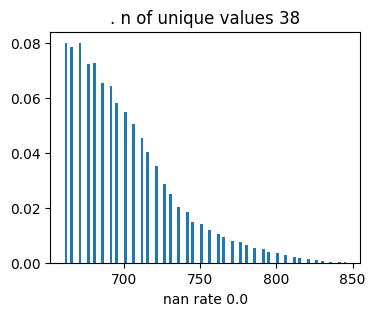

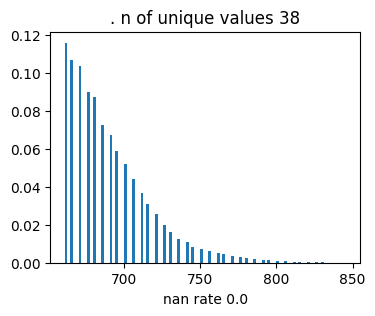

In [6]:
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp
from scipy.stats import bootstrap
from scipy.stats import mannwhitneyu

negative_staus_index = Y_train['loan_status'].loc[Y_train['loan_status']==0].index
positive_staus_index = Y_train['loan_status'].loc[Y_train['loan_status']==1].index


negative_delinq = X_train['acc_now_delinq'].loc[negative_staus_index].to_numpy() 
positive_delinq = X_train['acc_now_delinq'].loc[positive_staus_index].to_numpy()
rate_of_bad_acc_in_negative_group = np.sum(negative_delinq>0.0)/len(negative_delinq) 
rate_of_bad_acc_in_positive_group = np.sum(positive_delinq>0.0)/len(positive_delinq)

# stat1_ = lambda x: np.sum(x>0.0)/len(x)
# res1 = [ stat1_(negative_delinq[np.random.randint(0,negative_delinq.shape[0]-1,negative_delinq.shape[0])])  for i in range(1000)]
# res2 = [ stat1_(positive_delinq[np.random.randint(0,positive_delinq.shape[0]-1,positive_delinq.shape[0])])  for i in range(1000)]
# print(ks_2samp(res1,res2))
# print(mannwhitneyu(res1,res2))
# plot_float_distribution(res1,title='neg group')
# plot_float_distribution(res2,title='pos group')


print(rate_of_bad_acc_in_negative_group)
print(rate_of_bad_acc_in_positive_group)

negative_low = X_train['fico_range_low'].loc[negative_staus_index].to_numpy() 
positive_low = X_train['fico_range_low'].loc[positive_staus_index].to_numpy()

plot_float_distribution(negative_low)
plot_float_distribution(positive_low)
print(np.mean(negative_low))
print(np.mean(positive_low))
print(ttest_ind(negative_low,positive_low,equal_var=False))
print(ks_2samp(negative_low, positive_low))

# запрошенная - выданная 
neg_ =  X_train['loan_amnt'].loc[negative_staus_index].to_numpy()- X_train['funded_amnt'].loc[negative_staus_index].to_numpy()
pos_ =  X_train['loan_amnt'].loc[positive_staus_index].to_numpy()- X_train['funded_amnt'].loc[positive_staus_index].to_numpy()
print(ttest_ind(neg_,pos_))
print(neg_)
print(pos_)

# доли пропущенных mths_since_recent_bc_dlq 
neg_mths_since_recent_bc_dlq_nan =  X_train['mths_since_recent_bc_dlq'].loc[negative_staus_index].to_numpy() 
pos_mths_since_recent_bc_dlq_nan =  X_train['mths_since_recent_bc_dlq'].loc[positive_staus_index].to_numpy()
nan_rate_neg = np.sum(np.isnan(neg_mths_since_recent_bc_dlq_nan))/len(neg_mths_since_recent_bc_dlq_nan)
nan_rate_pos = np.sum(np.isnan(pos_mths_since_recent_bc_dlq_nan))/len(pos_mths_since_recent_bc_dlq_nan)
print(nan_rate_neg)
print(nan_rate_pos)


# № 3

value Not Verified P(default) 0.14906147168240383
value Source Verified P(default) 0.20017171183328494
value Verified P(default) 0.23128955086782998
group "Not Verified" annual_inc 72173.8650360748
group "Source Verified" annual_inc 82255.5716878939
group "Verified" annual_inc 78850.6698482642


<Axes: >

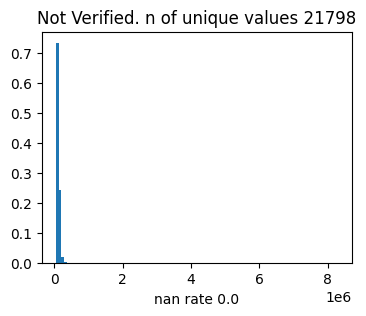

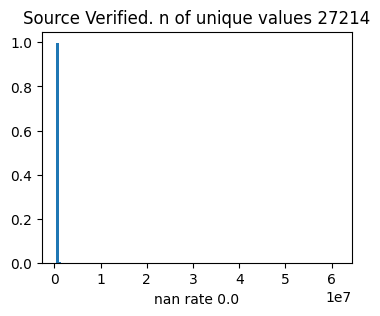

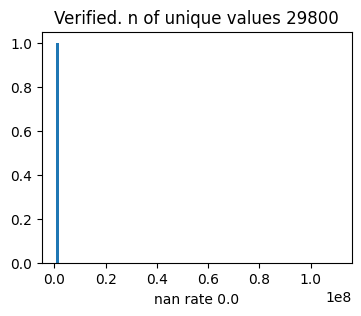

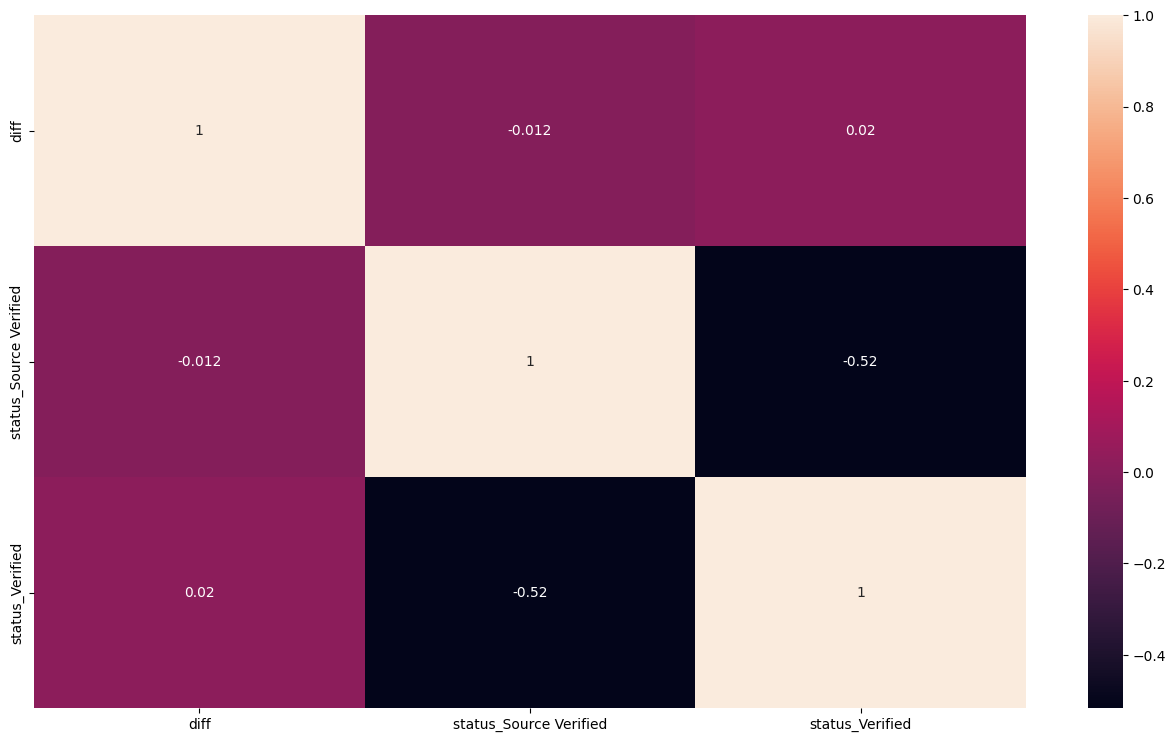

In [7]:

import seaborn as sns
def group_by_unique_values(table:pd.DataFrame,column_name):
    vs = np.unique(table[column_name].to_numpy())
    vs = vs[~pd.isna(vs)]
    groups = []
    for v in vs:
        gr_i = table[column_name].loc[table[column_name]==v]
        groups.append(gr_i)

    return vs,groups
# P of default for groups by verification status
vs,groups= group_by_unique_values(X_train,'verification_status')
for i in range(len(groups)):
    gr_i = groups[i]
    gr_target = Y_train['loan_status'].loc[gr_i.index].to_numpy()
    P_default = np.sum(gr_target==1)/len(gr_target)
    print('value {} P(default) {}'.format(vs[i],P_default))

for i in range(len(groups)):
    gr_i = groups[i]
    annual_inc = X_train['annual_inc'].loc[gr_i.index].to_numpy()
    plot_float_distribution(annual_inc,title=str(vs[i]))
    print('group "{}" annual_inc {}'.format(vs[i],np.mean(annual_inc)))


# correlation
diff_ = X_train['loan_amnt']-X_train['funded_amnt']
status_= X_train['verification_status'] # .map({'Not Verified': 1, 'Source Verified': 2,'Verified':3})
data_=pd.DataFrame(data={'diff':diff_,'status':status_})
data_ = pd.get_dummies(data_,columns=['status'],drop_first=True)
fig2, ax2 = plt.subplots(figsize=(16,9))
sns.heatmap(data_.corr(), ax=ax2, annot=True)

# № 5

In [8]:
targets_all = Y_train['loan_status'].to_numpy()
base_default_rate = np.sum(targets_all==1)/len(targets_all)
print(base_default_rate)
targets_special_indexes_mort_acc = X_train['mort_acc'].loc[X_train['mort_acc']>0.0].index.to_numpy()
targets_special_indexes_dti = X_train['dti'].loc[X_train['dti'] < 0.3].index.to_numpy()
target_special_indexes = np.intersect1d(targets_special_indexes_dti, targets_special_indexes_mort_acc)
special_targets = Y_train['loan_status'].loc[target_special_indexes].to_numpy()
print(len(special_targets))
special_default_rate = np.sum(special_targets==1)/len(special_targets)
print(special_default_rate)
print(base_default_rate-special_default_rate)

0.19302902586216236
660
0.14393939393939395
0.04908963192276841


# № 6

In [3]:
cat_features_ = [
    # 'addr_state', # 56
    'emp_length', # 12 
    'purpose', # 14
    'home_ownership', # 6 
    'verification_status', #3
    'term', #2
]
X_train_row = pd.read_csv(conf.X_train_reformated,index_col=False).drop(columns=['index'])
print(X_train_row.shape)
encoders = torch.load(conf.cat_encoders_path)
all_cat = list(encoders.keys())
rest = list(np.setdiff1d(all_cat, cat_features_))+['title']
print('dropped {}'.format(rest))
X_train_row.drop(columns=rest,inplace=True)
print(np.unique(X_train_row['purpose']))
X_train_row = pd.get_dummies(X_train_row,columns=cat_features_,drop_first=True,dummy_na=True)
X_train_row = X_train_row.fillna(-999)
print('list of columns {}'.format([el for el in X_train_row]))
print(X_train_row.shape)
y_train_row = pd.read_csv(conf.train_target,index_col=False).drop(columns='index')
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_row, y_train_row, test_size=0.33, random_state=100)
display(HTML(X_train2.head().to_html()))

(1199861, 44)
dropped ['addr_state', 'zip_code', 'title']
['car' 'credit_card' 'debt_consolidation' 'educational' 'home_improvement'
 'house' 'major_purchase' 'medical' 'moving' 'other' 'renewable_energy'
 'small_business' 'vacation' 'wedding']
list of columns ['acc_now_delinq', 'annual_inc', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'dti', 'earliest_cr_line', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'inq_last_12m', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'mort_acc', 'mths_since_last_delinq', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_rev_accts', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_il_24m', 'open_rv_24m', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'revol_util', 'tax_liens', 'total_acc', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 yea

,acc_now_delinq,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,fico_range_high,fico_range_low,funded_amnt,inq_last_12m,installment,int_rate,issue_d,loan_amnt,mort_acc,mths_since_last_delinq,mths_since_recent_bc_dlq,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_rev_accts,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_il_24m,open_rv_24m,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,revol_util,tax_liens,total_acc,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_nan,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Source Verified,verification_status_Verified,verification_status_nan,term_ 60 months,term_nan
471986,0,72000.0,0.0,0.0,0,4.93,2011.743802,704,700,12000.0,0.0,395.66,11,2016.661157,12000.0,0.0,-999.0,-999.0,15.0,0.0,3.0,10.0,7.0,0.0,0.0,0.0,0.0,7,0.0,3.0,40.0,0,0.0,51.0,0.0,10,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
1059996,0,48000.0,0.0,0.0,0,10.45,1999.578512,684,680,15000.0,-999.0,488.53,11,2013.661157,15000.0,2.0,-999.0,-999.0,9.0,0.0,4.0,10.0,7.0,0.0,0.0,0.0,2.0,7,-999.0,-999.0,75.0,0,0.0,80.0,0.0,14,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
1170907,0,41000.0,0.0,0.0,0,34.07,2001.826446,684,680,16000.0,-999.0,437.28,21,2013.413223,16000.0,0.0,81.0,-999.0,14.0,0.0,5.0,16.0,21.0,0.0,0.0,0.0,1.0,21,-999.0,-999.0,100.0,0,0.0,55.0,0.0,38,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False
15303,0,62000.0,0.0,0.0,1,19.28,1997.247934,669,665,24575.0,-999.0,919.45,20,2012.661157,24575.0,4.0,7.0,-999.0,8.0,-999.0,-999.0,-999.0,8.0,-999.0,-999.0,-999.0,-999.0,8,-999.0,-999.0,60.0,0,0.0,46.0,0.0,17,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False
64,0,110000.0,0.0,0.0,1,7.22,2004.165289,674,670,18050.0,-999.0,488.22,21,2014.661157,18050.0,1.0,13.0,-999.0,1.0,1.0,3.0,9.0,7.0,0.0,0.0,1.0,3.0,7,-999.0,-999.0,33.0,0,0.0,63.0,0.0,19,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False


In [4]:

clf = DecisionTreeClassifier(random_state=0)

In [5]:
clf.fit(X_train2,y_train2)

DecisionTreeClassifier(random_state=0)

In [6]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                      filled=True, rounded=True,  
                      special_characters=True)

In [7]:
graph = graphviz.Source(dot_data) 

In [8]:
graph

: 

: 